In [1]:
FILE_SUFFIX = "UNCROPPED_IMAGES"

# Load Data

In [49]:
import pandas as pd

data = pd.read_csv('data_reduced.csv', encoding="latin-1")
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,...,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flatness_mean,spectral_flatness_std,tempogram_mean,tempogram_std
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,funk,138,1,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,...,0.034636,0.058105,5335.603726,2688.930490,4615.955290,1007.859698,0.092827,0.133516,0.239535,0.137067
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,funk,102,1,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,...,0.030456,0.063953,6338.191486,3683.342441,4989.509117,1157.665970,0.142638,0.155706,0.139604,0.163539
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,funk,105,1,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,...,0.037484,0.067771,6077.338238,3792.722720,4680.404598,1377.311199,0.124579,0.146646,0.179192,0.130047
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,funk,86,1,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,...,0.022330,0.049949,5542.225095,3417.495525,4875.089779,1265.250954,0.106046,0.138443,0.208746,0.174764
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,funk,80,1,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,...,0.021056,0.051182,7714.574395,3887.263988,5119.254721,1091.703500,0.188627,0.157474,0.129188,0.149107


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   drummer                  1090 non-null   object 
 1   session                  1090 non-null   object 
 2   id                       1090 non-null   object 
 3   style                    1090 non-null   object 
 4   simplified_style         1090 non-null   object 
 5   bpm                      1090 non-null   int64  
 6   beat_type                1090 non-null   int64  
 7   time_signature           1090 non-null   object 
 8   midi_filename            1090 non-null   object 
 9   audio_filename           1090 non-null   object 
 10  duration                 1090 non-null   float64
 11  split                    1090 non-null   object 
 12  onset_env_mean           1090 non-null   float64
 13  onset_env_std            1090 non-null   float64
 14  mfcc_mean               

# Prepare Data

In [51]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
data["encoded_style"] = label_encoder.fit_transform(data.simplified_style)
data.encoded_style.value_counts()

encoded_style
5    377
0    264
3    174
2    121
1     95
4     59
Name: count, dtype: int64

In [52]:
# add the column spectrum_filename to the dataframe data. But not at the end, instead it should follow the column audio_filename
data.insert(data.columns.get_loc('audio_filename') + 1, 'spectrum_filename', '')

In [53]:
data['spectrum_filename'] = data.audio_filename.str.replace('.wav', '.png')

In [54]:
data['spectrum_filename'][0]

'drummer1/eval_session/1_funk-groove1_138_beat_4-4.png'

In [55]:
from sklearn.model_selection import train_test_split

# Split the data
data_train, data_test = train_test_split(data, test_size=0.15, random_state=42)

# Split again into validation and test (Split is now 70/15/15)
data_test, data_validation = train_test_split(data_test, test_size=0.5, random_state=42,)
data_test.shape

(82, 34)

In [56]:
# check the distribution after the split
print(data_train.shape, data_test.shape, data_validation.shape, )
print("Train data share: ", data_train.shape[0] / data.shape[0])
print("Validation data share: ", data_validation.shape[0]/ data.shape[0])
print("Test data share: ", data_test.shape[0] / data.shape[0])

(926, 34) (82, 34) (82, 34)
Train data share:  0.8495412844036697
Validation data share:  0.07522935779816514
Test data share:  0.07522935779816514


# Convolutional Neural Network

Image Generators are the dataloaders for the CNN. They just define how the images are "fed" to the cnn, like where is the path to the images, what are the labels to predict

In [57]:
data_test.head()

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,...,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flatness_mean,spectral_flatness_std,tempogram_mean,tempogram_std,encoded_style
832,drummer7,drummer7/session2,drummer7/session2/71,rock,rock,145,0,4-4,drummer7/session2/71_rock_145_fill_4-4.mid,drummer7/session2/71_rock_145_fill_4-4.wav,...,0.062861,3381.140440,2265.282711,3396.294774,1000.917057,0.018660,0.042620,0.259885,0.203409,5
1000,drummer7,drummer7/session3,drummer7/session3/8,rock,rock,60,0,4-4,drummer7/session3/8_rock_60_fill_4-4.mid,drummer7/session3/8_rock_60_fill_4-4.wav,...,0.031750,3559.509113,3473.918598,4422.523547,3632.891501,0.312436,0.459574,0.170559,0.169325,5
1042,drummer8,drummer8/session1,drummer8/session1/19,funk,funk,108,1,4-4,drummer8/session1/19_funk_108_beat_4-4.mid,drummer8/session1/19_funk_108_beat_4-4.wav,...,0.055380,6798.618182,3420.107803,5175.153452,1296.445191,0.132570,0.153477,0.174429,0.134453,0
83,drummer1,drummer1/session1,drummer1/session1/165,latin/brazilian/baiao,latin,95,0,4-4,drummer1/session1/165_latin-brazilian-baiao_95...,drummer1/session1/165_latin-brazilian-baiao_95...,...,0.027562,5339.585561,3156.481155,4537.173292,1506.679443,0.079025,0.092924,0.166883,0.142043,3
136,drummer1,drummer1/session1,drummer1/session1/212,rock/halftime,rock,140,0,4-4,drummer1/session1/212_rock-halftime_140_fill_4...,drummer1/session1/212_rock-halftime_140_fill_4...,...,0.077485,3263.080536,1905.318771,3559.406136,1148.536689,0.027094,0.053171,0.086951,0.078124,5


In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

path_images = os.path.join('..', 'Datasets', 'spectrums')
print(path_images)

IMG_HEIGHT_OFFSET = 89
IMG_WIDTH_OFFSET = 35
IMG_HEIGHT = 307
IMG_WIDTH = 717
BATCH_SIZE = 32

# Define the custom preprocessing function
def crop_image(image):
    cropped_image = tf.image.crop_to_bounding_box(image,
                                                  offset_height = IMG_HEIGHT_OFFSET, 
                                                  offset_width = IMG_WIDTH_OFFSET, 
                                                  target_height = IMG_HEIGHT, 
                                                  target_width = IMG_WIDTH)
    return cropped_image

# Normalize images and add the custom preprocessing function
image_generator = ImageDataGenerator(
    rescale=1.0/255,
    preprocessing_function=crop_image
)

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
    dataframe=data_train,
    directory=path_images,
    x_col="spectrum_filename",
    y_col="simplified_style",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    color_mode="rgb" # add color mode
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=data_validation,
    directory=path_images,
    x_col="spectrum_filename",
    y_col="simplified_style",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    color_mode="rgb", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=data_test,
    directory=path_images,
    x_col="spectrum_filename",
    y_col="simplified_style",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    color_mode="rgb", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

..\Datasets\spectrums
Found 757 validated image filenames belonging to 6 classes.
Found 68 validated image filenames belonging to 6 classes.
Found 68 validated image filenames belonging to 6 classes.


d:\Programmierung\anaconda3\envs\audio_data_science_gpu\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 169 invalid image filename(s) in x_col="spectrum_filename". These filename(s) will be ignored.
  warnings.warn(
d:\Programmierung\anaconda3\envs\audio_data_science_gpu\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 14 invalid image filename(s) in x_col="spectrum_filename". These filename(s) will be ignored.
  warnings.warn(
d:\Programmierung\anaconda3\envs\audio_data_science_gpu\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 14 invalid image filename(s) in x_col="spectrum_filename". These filename(s) will be ignored.
  warnings.warn(


In [59]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Define the input shape
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(6, activation='softmax')  # 6 output neurons for 6 classes
])

cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 248, 98, 32)       896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 124, 49, 32)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 122, 47, 64)       18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 61, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 59, 21, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 29, 10, 128)     

In [60]:
import tensorflow as tf

def compileCNN(cnn):
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    # Compile the model
    cnn.compile(optimizer='adam',
                loss='categorical_crossentropy', # used for one-hot encoded labels, which is done by the ImageDataGenerator
                metrics="accuracy") #metrics)
    
    return cnn

In [61]:
def createCallbacks(path):
    # Create a callback that saves the model's weights
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                    save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                    verbose=1, 
                                                    monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                    mode='max',                # the greatest accuracy on the validation is the best outcome
                                                    save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    return checkpoint_cb, early_stopping_cb

In [62]:
def trainCNN(cnn, train_generator, validation_generator, checkpoint_callback, early_stopping_callback):
    history = cnn.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[checkpoint_callback, early_stopping_callback],  # Pass callback to training
    )
    return cnn

In [63]:
filename = 'multiclass_cnn_' + FILE_SUFFIX + '.ckpt'
cnn_path = os.path.join('..', 'data', 'models', filename)

try:
    cnn_model.load_weights(cnn_path)
except:
    cnn_model = compileCNN(cnn_model)
    checkpoint_callback, early_stopping_callback = createCallbacks(cnn_path)
    cnn_model = trainCNN(cnn_model, train_generator, val_generator, checkpoint_callback, early_stopping_callback)

In [64]:
cnn_model = compileCNN(cnn_model)
checkpoint_callback, early_stopping_callback = createCallbacks(cnn_path)
cnn_model = trainCNN(cnn_model, train_generator, val_generator, checkpoint_callback, early_stopping_callback)

Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 1.7732 - accuracy: 0.2787
Epoch 1: val_accuracy improved from -inf to 0.39706, saving model to data\models\multiclass_cnn.ckpt
24/24 [==============================] - 12s 397ms/step - loss: 1.7732 - accuracy: 0.2787 - val_loss: 1.5694 - val_accuracy: 0.3971
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 1.6239 - accuracy: 0.3342
Epoch 2: val_accuracy improved from 0.39706 to 0.47059, saving model to data\models\multiclass_cnn.ckpt
24/24 [==============================] - 8s 339ms/step - loss: 1.6239 - accuracy: 0.3342 - val_loss: 1.5637 - val_accuracy: 0.4706
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 1.6258 - accuracy: 0.3118
Epoch 3: val_accuracy did not improve from 0.47059
24/24 [==============================] - 6s 245ms/step - loss: 1.6258 - accuracy: 0.3118 - val_loss: 1.5062 - val_accuracy: 0.3971
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 

In [65]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

3/3 [==============================] - 1s 128ms/step - loss: 1.4717 - accuracy: 0.3971
Test Accuracy: 39.71%


In [66]:
import numpy as np

# Predict the labels for the test set
test_generator.reset()  # Resetting ensures the generator starts from the beginning
predictions = cnn_model.predict(test_generator)

# Convert predictions to class indices (if using softmax output)
predicted_classes = np.argmax(predictions, axis=1)

# True labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get the class labels

3/3 [==============================] - 1s 134ms/step


d:\Programmierung\anaconda3\envs\audio_data_science_gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmierung\anaconda3\envs\audio_data_science_gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmierung\anaconda3\envs\audio_data_science_gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Classification Report:
               precision    recall  f1-score   support

        funk       0.43      0.55      0.48        29
      hiphop       0.00      0.00      0.00         6
        jazz       0.00      0.00      0.00         2
       latin       0.50      0.20      0.29        10
         pop       0.00      0.00      0.00         2
        rock       0.33      0.47      0.39        19

    accuracy                           0.40        68
   macro avg       0.21      0.20      0.19        68
weighted avg       0.35      0.40      0.36        68

Hamming Loss: 0.6029411764705882


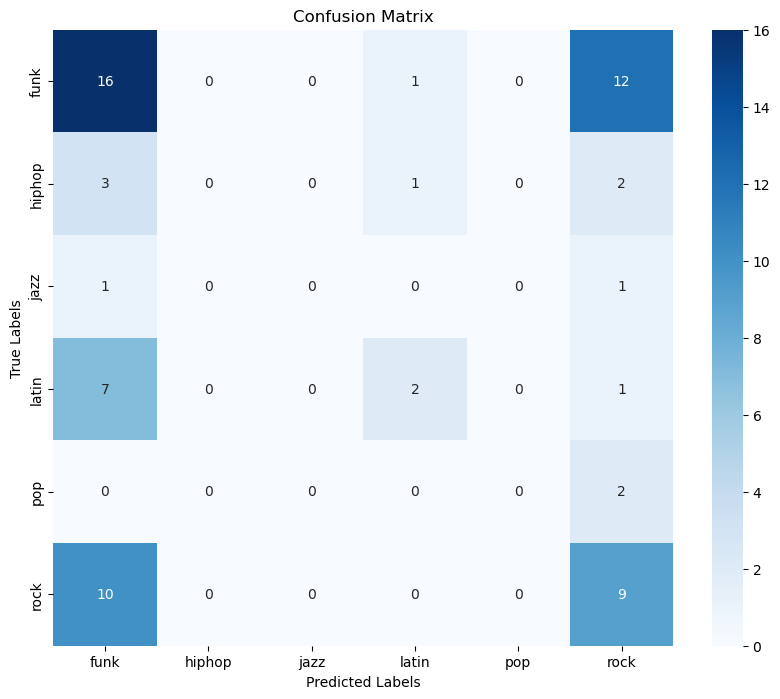

In [67]:
from sklearn.metrics import classification_report, hamming_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Hamming Loss
h_loss = hamming_loss(true_classes, predicted_classes)
print("Hamming Loss:", h_loss)

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Convert the classification report to a markdown table
def convert_to_markdown(report, hamming_loss, image_path=None):
    lines = report.strip().split('\n')
    headers = lines[0].split()
    table = "| " + " | ".join(headers) + " |\n"
    table += "| " + " | ".join(['---'] * len(headers)) + " |\n"
    
    for line in lines[1:]:
        row = " | ".join(line.split())
        table += "| " + row + " |\n"
    
    markdown_content = f"# Classification Report for {FILE_SUFFIX}\n\n"
    markdown_content += f"__Hamming Loss__ = {hamming_loss}\n\n{table}\n"
    
    if image_path:
        markdown_content += f"\n![Image]({image_path})\n"
    
    return markdown_content

eval_path = os.path.join('..', 'evaluation')
conf_matrix_path = os.path.join(eval_path, 'images', 'confusion_matrix_' + FILE_SUFFIX + '.png')
markdwon_path = os.path.join(eval_path, 'markdown', 'classification_report_' + FILE_SUFFIX + '.md')
plt.savefig(conf_matrix_path)

# Generate markdown content
markdown_content = convert_to_markdown(report, h_loss, conf_matrix_path)

# Write to a markdown file
with open(markdwon_path, "w") as file:
    file.write(markdown_content)